## Import dataset

In [1]:
import pandas as pd

toxic_comments = pd.read_csv("data/train.csv")

filter = toxic_comments['comment_text'] != ""
toxic_comments = toxic_comments[filter]
toxic_comments = toxic_comments.dropna()

## Preprocess dataset

In [2]:
import re

def preprocess_text(s):
    sentence = re.sub('[^a-zA-Z]', ' ', s)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

X = []
sentences = list(toxic_comments["comment_text"])
for s in sentences:
    X.append(preprocess_text(s))

toxic_comments_labels = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
y = toxic_comments_labels.values

## Split data into Training and Test sets

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Vectorize textual feature

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import asarray, zeros

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

glove_file = open('data/glove.6B.100d.txt', encoding="utf8")

embeddings_dictionary = dict()
for line in glove_file:
    records = line.split()
    word = records[0]
    vector = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector
    
glove_file.close()

vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    vector = embeddings_dictionary.get(word)
    if vector is not None:
        embedding_matrix[index] = vector

Using TensorFlow backend.


## Create Model

In [5]:
from keras.layers import Input, LSTM
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense
from keras.models import Model

deep_input = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_input)
LSTM_layer = LSTM(128)(embedding_layer)
dense_layer = Dense(6, activation='sigmoid')(LSTM_layer)

model = Model(inputs=deep_input, outputs=dense_layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          14824300  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 14,942,322
Trainable params: 118,022
Non-trainable params: 14,824,300
_________________________________________________________________
None


## Train the model

In [6]:
trained_model = model.fit(X_train, y_train, batch_size=128, epochs=2, verbose=1, validation_split=0.2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/2
102124/102124 [==============================] - 460s 5ms/step - loss: 0.1231 - acc: 0.9663 - val_loss: 0.0683 - val_acc: 0.9779
Epoch 2/2
102124/102124 [==============================] - 438s 4ms/step - loss: 0.0625 - acc: 0.9790 - val_loss: 0.0613 - val_acc: 0.9799


## Evaluate the model

In [7]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

31915/31915 [==============================] - 55s 2ms/step
Test Score: 0.05973513932315305
Test Accuracy: 0.9801981449127197


## Plot the loss and accuracy

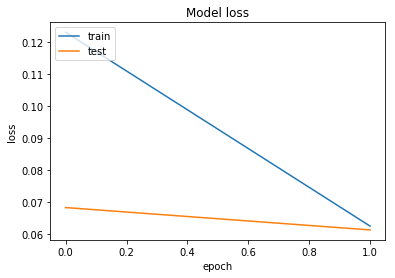

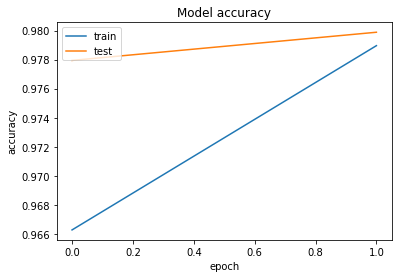

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(trained_model.history['acc'])
plt.plot(trained_model.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Save the model

In [10]:
import pickle

filename = 'model_single_output.sav'
pickle.dump(model, open(filename, 'wb'))